In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), ".."))

In [2]:
from system.controller.reachability_estimator.networks import Model, get_grid_cell
from system.controller.reachability_estimator.ReachabilityDataset import SampleConfig
from system.controller.reachability_estimator.training.train_multiframe_dst import _load_weights, DATA_STORAGE_FOLDER, Hyperparameters, process_batch

config = SampleConfig(
    grid_cell_spikings=False,
    lidar=False,
    images=False,
    dist=True,
)
network_config = {
    'image_encoder': 'conv',
}
dataset_features = []

dataset_features = ''.join(f'-{feature}' for feature in dataset_features)
suffix = dataset_features + config.suffix()
if network_config['image_encoder'] == 'conv':
    suffix += '+conv'

model_filename = "reachability_network"
model_dir = DATA_STORAGE_FOLDER

model_filename = model_filename + suffix
model_file = os.path.join(model_dir, model_filename)

nets = Model.create_from_config("convolutional", config, **network_config)
epoch = _load_weights(model_file, nets)
print("Loaded epoch", epoch)

pybullet build time: Apr 30 2024 14:40:07
2024-07-05 19:30:52.076528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loaded epoch 25


In [3]:
nets.nets

{'angle_regression': AngleRegression(
   (fc): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 'position_regression': PositionRegression(
   (fc): Linear(in_features=4, out_features=2, bias=True)
 ),
 'reachability_regression': ReachabilityRegression(
   (fc): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 'fully_connected': FCLayers(
   (fc): Sequential(
     (0): Linear(in_features=3, out_features=256, bias=True)
     (1): ReLU()
     (2): Linear(in_features=256, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=4, bias=True)
   )
 )}

In [4]:
import torch
import torch.nn as nn
fc = nets.nets['fully_connected'].fc
for i, layer in enumerate(fc):
    if type(layer) == nn.Linear:
        print(f"fc[{i}] = Linear(weights<{fc[i].weight.shape}>, bias<{fc[i].bias.shape}>)")
        fc[i].weight.data.fill_(0.0)
        fc[i].bias.data.fill_(0.0)

fc[0] = Linear(weights<torch.Size([256, 3])>, bias<torch.Size([256])>)
fc[2] = Linear(weights<torch.Size([256, 256])>, bias<torch.Size([256])>)
fc[4] = Linear(weights<torch.Size([4, 256])>, bias<torch.Size([4])>)


In [5]:
from system.controller.reachability_estimator.ReachabilityDataset import ReachabilityDataset
from system.controller.reachability_estimator.types import img_reshape, Sample

In [6]:
dataset = ReachabilityDataset("dataset.hd5", sample_config=config)
next(iter(dataset))

([tensor(nan),
  tensor(nan),
  tensor([0., 0., 0.]),
  tensor(nan),
  tensor(nan),
  tensor(nan),
  tensor(nan)],
 (tensor(0.), tensor([0., 0.]), tensor(0.)))

In [7]:
import numpy as np
from tqdm import tqdm

distances = []
labels = []

# TODO Pierre: could be made more efficient with batching
for sample, ground_truth in tqdm(dataset):
    distance = np.linalg.norm(sample[2][0:2])
    reachable = ground_truth[0]
    distances.append(distance)
    labels.append(reachable)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14000/14000 [00:33<00:00, 417.76it/s]


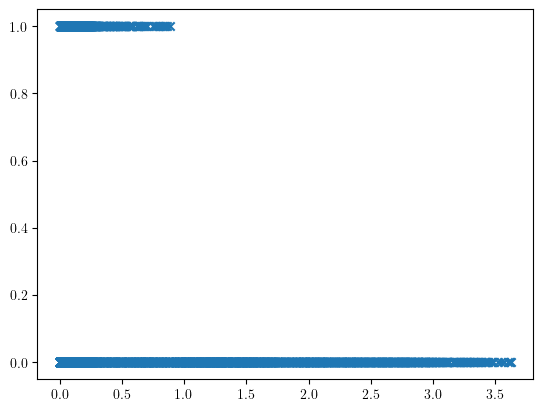

In [8]:
import matplotlib.pyplot as plt
plt.scatter(distances, labels, marker='x')

In [9]:
print(sum(labels) / len(labels))

tensor(0.2636)


In [10]:
step = 0.1
bucket_starts = np.arange(0.0, 4.0, 0.1)
buckets = [ [ 0, 0 ] for _ in bucket_starts ]
for distance, label in tqdm(zip(distances, labels)):
    bucket = buckets[int(distance / step)]
    bucket[0] += 1
    bucket[1] += int(label)
percentage = [ (bu[1] / bu[0] if bu[0] != 0 else 0) for bu in buckets ]

14000it [00:00, 110137.31it/s]


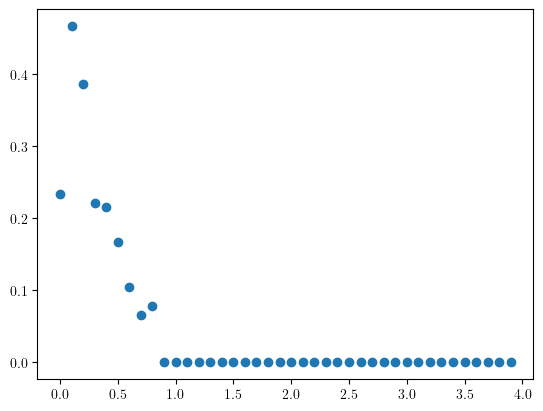

In [11]:
plt.scatter(bucket_starts, percentage)